<a href="https://www.kaggle.com/code/abhinavbhuyan/customer-churn-eda-classification-analysis?scriptVersionId=95635888" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id=0></a>
## [Introduction](#0)
We perform customer churn prediction on a bank customer dataset. The task is to predict whether a customer will exit the bank or not, based on his/her characteristics.

## Stages
1. [EDA](#1)
    - Plot distributions of customers based on various features such as age, geography, income etc.
    - Plot conditional distributions of these features for exiting/retained customers to derive insights
2. [Preprocessing and Feature engineering](#2)
    - Convert categorical features to one-hot representation for classification
    - Split data into train and test sets for features and target
3. [Logistic Regression Model](#3)
    - Training: Fit logistic regression model to train data and make predictions on test data
    - Evaluation: Plot confusion matrix and ROC curve and compute area under ROC curve
4. [Decision Tree Model](#4)
    - Training: Fit decision tree model to train data and make predictions on test data
    - Plot decision tree for visualization of decision nodes
    - Evaluation: Plot confusion matrix and ROC curve and compute area under ROC curve
    - Causal inference: Analyze important features for trained model
5. [Random Forest Model](#5)
    - Training: Fit random forest model to train data and make predictions on test data
    - Evaluation: Plot confusion matrix and ROC curve and compute area under ROC curve
    - Causal inference: Analyze important features for trained model

### Imports

In [1]:
# Core
import numpy as np
import pandas as pd

# ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, accuracy_score, balanced_accuracy_score

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

<a id=1></a> 
## 1. EDA

In [2]:
# Load data
df_churn = pd.read_csv('../input/churn-for-bank-customers/churn.csv')
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Let's tranform some of the binary features from numerical (0/1) to categorical for better interpretability and visualization.

In [3]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Feature Engineering
Let's convert some of the binary features to categorical for better interpretability 

In [4]:
df_churn.rename(columns={'HasCrCard': 'Credit Card Status', 'IsActiveMember': 'Activity', 'Exited': 'Status'}, inplace=True)
df_churn.Status = df_churn.Status.map({0: 'Retained', 1: 'Exited'})
df_churn['Credit Card Status'] = df_churn['Credit Card Status'].map({0: 'No Credit Card', 1: 'Has Credit Card'})
df_churn.Activity = df_churn.Activity.map({0: 'Inactive', 1: 'Active'})
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,Credit Card Status,Activity,EstimatedSalary,Status
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,Has Credit Card,Active,101348.88,Exited
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,No Credit Card,Active,112542.58,Retained
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,Has Credit Card,Inactive,113931.57,Exited
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,No Credit Card,Inactive,93826.63,Retained
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,Has Credit Card,Active,79084.10,Retained


First, let's examine the dataset for missing values

<AxesSubplot:>

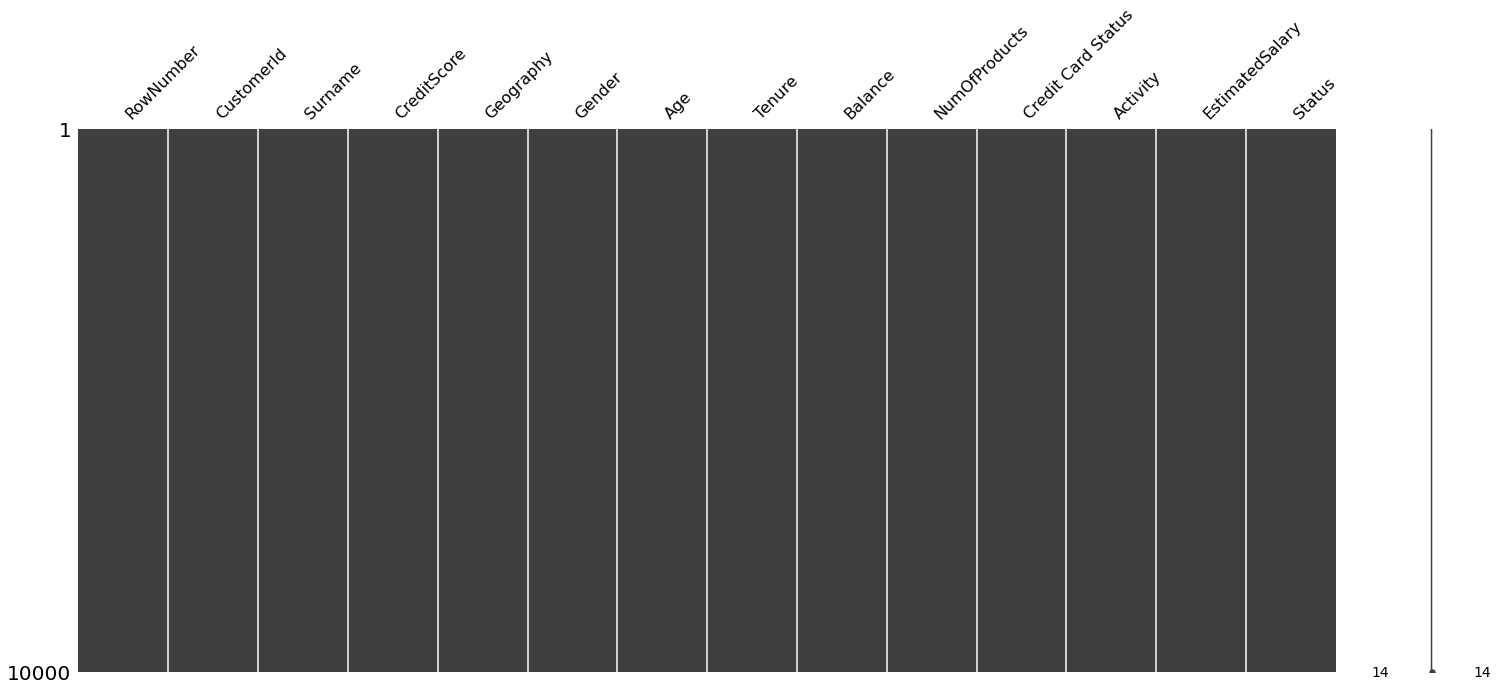

In [5]:
# Check missing values
msno.matrix(df_churn)

No missing values detected

Let's examine some characteristics of the bank's customers. First, let's look at the division of male and female customers.

In [6]:
px.pie(df_churn, names='Gender', hole=0.5)

The bank has slightly more male customers than female.
Where do the customers come from? Let's take a look!

In [7]:
px.pie(df_churn, names='Geography', hole=0.5)

Around half of the bank's customers are French, while the rest are split equally between Germany and Spain. 
How old are the clients? Go figure.

In [8]:
px.histogram(df_churn, x='Age', color='Status')

The age follows a roughly normal distribution with a mean of around 35 years.

Next, let's check the fraction of customers who exited, i.e., the % churn

In [9]:
px.pie(df_churn,names='Status',title='Percentage Churn', hole=0.5)

Roughly a fifth of the customers exited, corresponding to 20% churn.

Next, let's plot the distribution of credit scores for the customers

In [10]:
px.histogram(df_churn, x='CreditScore', color='Status')

The credit scores follow a normal distribution with a mean of roughly 650, and a large number of outliers with high credit scores. But there's no noticeable difference in scores for exiting and retained customers.

Let's study the tenure of customers.

In [11]:
px.box(df_churn, x='Tenure', color='Status')

The distribution is roughly uniform, with tenure ranging between 1–10 years, and an avg tenure of around 5 years for both groups. The exiting customers have a wider spread of tenures, but we can't draw very useful insights from this.

Next, let us look at bank balances.

In [12]:
px.histogram(df_churn, x='Balance', color='Status')

Balances follow a normal distribution with a mean of around 125k, but there are quite a few accounts with zero balance. Again, no clear differences for exiting and retained customers. 

What about salaries? Let's investigate!

In [13]:
px.histogram(df_churn, x='EstimatedSalary', color='Status')

The projected salaries follow a roughly uniform distribution ranging between 0–200k, with a mean of around 100k. This is the same for both exiting and retained customers.
How many of the customers have a credit card? Could this be an indicator of loyalty?


In [14]:
fig = px.sunburst(df_churn, path=['Credit Card Status', 'Status'])
fig.update_traces(textinfo='label + percent parent')

Around 29% of the clients don't have a credit card. We might expect that clients with credit cards are less likely to leave, but in fact the retention % is the same for both groups (around 80%).
What about activity, then? Surely, more active clients are less likely to leave?

In [15]:
fig = px.sunburst(df_churn, path=['Activity', 'Status'])
fig.update_traces(textinfo='label + percent parent')

Our intuition seems to be validated. Around half the customers are active. But around 27% of the inactive group leave the bank, while the fraction is much lower (14%) among active participants.
Finally, let's look at the number of bank products a client has subscribed to. We might expect that this would also be an indicator of loyalty.

In [16]:
fig = px.sunburst(df_churn, path=['NumOfProducts', 'Status'])
fig.update_traces(textinfo='label + percent parent')

Again, our intuition seems to be correct. Half the customers subscribe to only 1 product, and the rest mostly subscribe to 2 products (a small fraction subscribes to more than 2). But while 28% of the customers subscribing to only 1 product exit, only 8% of those subscribing to 2 products do so. So, subscriptions (i.e., more products) might be an indicator of loyalty.

<a id=2></a>
## Preprocessing and Feature engineering

First, let's drop the redundant columns

In [17]:
df_churn.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'Credit Card Status', 'Activity', 'EstimatedSalary', 'Status'],
      dtype='object')

In [18]:
df_churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
df_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,Credit Card Status,Activity,EstimatedSalary,Status
0,619,France,Female,42,2,0.00,1,Has Credit Card,Active,101348.88,Exited
1,608,Spain,Female,41,1,83807.86,1,No Credit Card,Active,112542.58,Retained
2,502,France,Female,42,8,159660.80,3,Has Credit Card,Inactive,113931.57,Exited
3,699,France,Female,39,1,0.00,2,No Credit Card,Inactive,93826.63,Retained
4,850,Spain,Female,43,2,125510.82,1,Has Credit Card,Active,79084.10,Retained


Next, we need to handle the categorical features. For this, we create a binary one-hot encoding for each class in each categorical feature, indicating if the data point contains that class. For our simple dataset, the pandas get_dummies function will suffice.

In [19]:
pd.get_dummies(df_churn)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Credit Card Status_Has Credit Card,Credit Card Status_No Credit Card,Activity_Active,Activity_Inactive,Status_Exited,Status_Retained
0,619,42,2,0.00,1,101348.88,1,0,0,1,0,1,0,1,0,1,0
1,608,41,1,83807.86,1,112542.58,0,0,1,1,0,0,1,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,0,0,1,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,1,0,0,1,0,0,1,0,1,0,1
4,850,43,2,125510.82,1,79084.10,0,0,1,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,96270.64,1,0,0,0,1,1,0,0,1,0,1
9996,516,35,10,57369.61,1,101699.77,1,0,0,0,1,1,0,1,0,0,1
9997,709,36,7,0.00,1,42085.58,1,0,0,1,0,0,1,1,0,1,0
9998,772,42,3,75075.31,2,92888.52,0,1,0,0,1,1,0,0,1,1,0


In [20]:
X = df_churn.iloc[:, :-1]
X = pd.get_dummies(X)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Credit Card Status_Has Credit Card,Credit Card Status_No Credit Card,Activity_Active,Activity_Inactive
0,619,42,2,0.00,1,101348.88,1,0,0,1,0,1,0,1,0
1,608,41,1,83807.86,1,112542.58,0,0,1,1,0,0,1,1,0
2,502,42,8,159660.80,3,113931.57,1,0,0,1,0,1,0,0,1
3,699,39,1,0.00,2,93826.63,1,0,0,1,0,0,1,0,1
4,850,43,2,125510.82,1,79084.10,0,0,1,1,0,1,0,1,0


In [21]:
# Set target as the exit status
y = df_churn.Status

In [22]:
# Split data intro training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id=3></a>
## 3. Logistic Regression Model
In statistics, the (binary) logistic model (or logit model) is a statistical model that models the probability of one event (out of two alternatives) taking place by having the log-odds (the logarithm of the odds) for the event be a linear combination of one or more independent variables ("predictors"). In regression analysis, logistic regression[1] (or logit regression) is estimating the parameters of a logistic model (the coefficients in the linear combination). Formally, in binary logistic regression there is a single binary dependent variable, coded by a indicator variable, where the two values are labeled "0" and "1", while the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value). The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling;[2] the function that converts log-odds to probability is the logistic function, hence the name. [Source](https://en.wikipedia.org/wiki/Logistic_regression)

### Training

In [23]:
# Initialize LR model
lr_model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, class_weight='balanced',
                              random_state=42, solver='lbfgs', max_iter=100, verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# Fit to train data
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

### Evaluation and Viz

In [24]:
# Use trained model to make predictions on test data
y_pred = lr_model.predict(X_test)

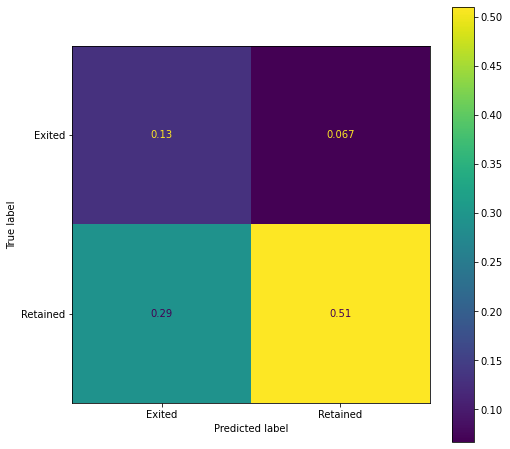

In [25]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax)
plt.show()

We have an imbalanced dataset, and we want to examine how the model performs for a range of cutoff probabilities. A useful metric is the Receiving Operating Characteristic (ROC).
A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The method was originally developed for operators of military radar receivers starting in 1941, which led to its name.
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. [Source](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

Text(0.5, 0.98, 'ROC Curve for LR Model')

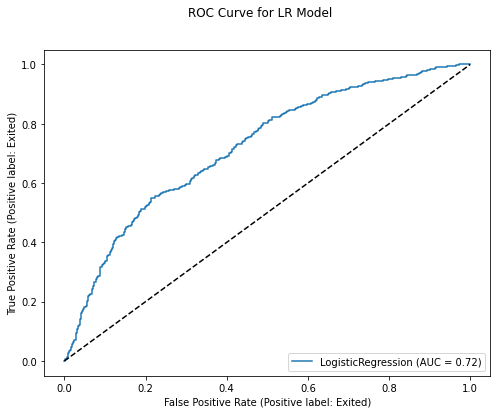

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr_model, X_test, y_test, pos_label='Exited', ax=ax)
ax.plot([0, 1], [0, 1], 'k--' )
fig.suptitle('ROC Curve for LR Model')

Let's calculate the total area under the ROC curve, which gives a better indication of model power and accuracy over a range of probability cutoffs. 

In [27]:
# Calculate area under roc curve
y_pred_prob = lr_model.predict_proba(X_test) 
roc_auc_score(y_test, y_pred_prob[:, 1])

0.7201714509200365

While this is surely better than random, it doesn't seem to be a very good clasifier? Can we improve upon this by using more sophisticated models?

<a id=4></a>
## 4. Decision Tree Model

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation. [Source](https://scikit-learn.org/stable/modules/tree.html)

### Training

In [28]:
# Initialize model with parameters
dt_model = DecisionTreeClassifier(max_depth=30, min_samples_split=50, min_samples_leaf=25, 
                                  max_leaf_nodes=100, class_weight='balanced', ccp_alpha=0.0001)
# Fit model to training data
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight='balanced', max_depth=30,
                       max_leaf_nodes=100, min_samples_leaf=25,
                       min_samples_split=50)

### Evaluation and Viz

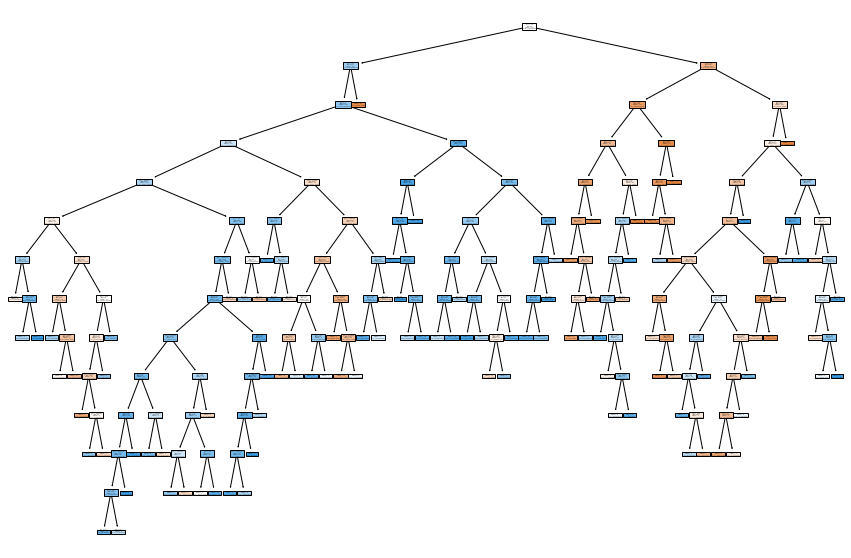

In [29]:
# Plot tree
plt.figure(figsize=(15, 10))
tree.plot_tree(dt_model, filled=True)
plt.show()

Let's evalutate the predictions of our DT model

In [30]:
# Use trained model to make predictions on test data
y_pred = dt_model.predict(X_test)

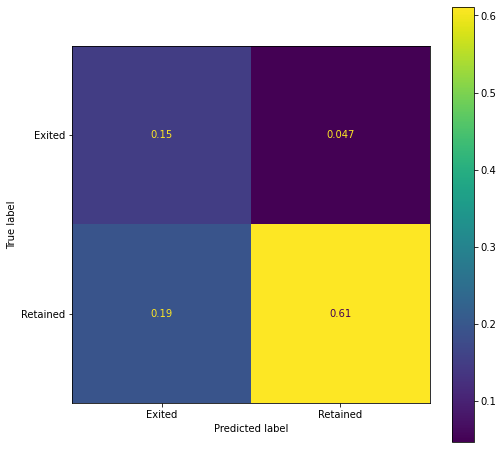

In [31]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax)
plt.show()

Text(0.5, 0.98, 'ROC Curve for DT Model')

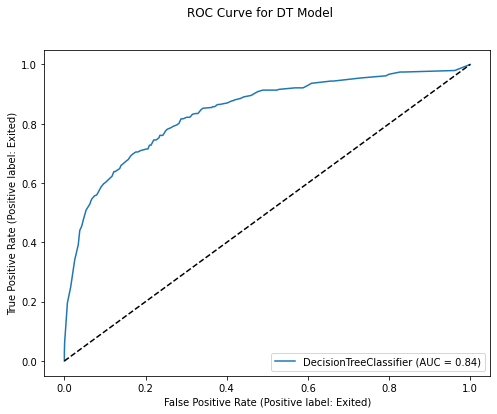

In [32]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(dt_model, X_test, y_test, pos_label='Exited', ax=ax)
ax.plot([0, 1], [0, 1], 'k--' )
fig.suptitle('ROC Curve for DT Model')

In [33]:
# Calculate area under roc curve
y_pred_prob = dt_model.predict_proba(X_test) 
roc_auc_score(y_test, y_pred_prob[:, 1])

0.8392718877810343

An important part of ML is causal inference. This analyzes the decisions made by the model, which factors contribute to a particular decision. This allows us to understand the model's mechanism and improves robustness and trust in the model.
One instance of this is feature importance analysis. This basically detects the most important features for the (fitted) model. This is done by randomly removing features from the training task and measuring the increase in impurity/misclassification for each feature. Next, let's examine which features are the most important for this classification task (according to the DT model). 

In [34]:
px.bar(x=dt_model.feature_names_in_, y=dt_model.feature_importances_)

The most important factor for determining whether customers stay or exit seems to be age, folowed by the num of products subscribed (a proxy for loyalty). This also confirms what we had discovered with our descriptive stats. Other important features are the account balance and activity.
The decision tree model performs significantly better than the logistic regression model (as seen with the roc-auc scores). This is not surprsing as the DT model is more sophisticated and better suited for such tasks. But can we improve even further? 

<a id=5></a>
## 5. Random Forests
In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features.

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model. [Source](https://scikit-learn.org/stable/modules/ensemble.html)

### Training

In [35]:
# Initialize random forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=30, min_samples_split=50,
                                  min_samples_leaf=25, min_weight_fraction_leaf=0.0, max_features='sqrt',
                                  max_leaf_nodes=100, min_impurity_decrease=0.0001, bootstrap=True, 
                                  oob_score=False, n_jobs=-1, random_state=42, verbose=0, warm_start=False, 
                                  class_weight='balanced', ccp_alpha=0.0001, max_samples=None)

In [36]:
# Fit to training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0001, class_weight='balanced', max_depth=30,
                       max_features='sqrt', max_leaf_nodes=100,
                       min_impurity_decrease=0.0001, min_samples_leaf=25,
                       min_samples_split=50, n_jobs=-1, random_state=42)

### Evaluation and Viz

In [37]:
# Use trained model to make predictions on test data
y_pred = rf_model.predict(X_test)

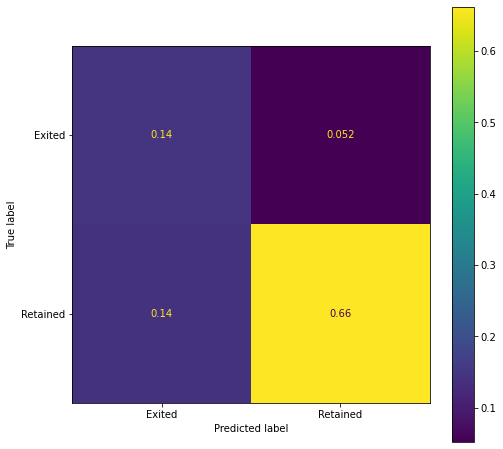

In [38]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax)
plt.show()

Text(0.5, 0.98, 'ROC Curve for Random Forest Model')

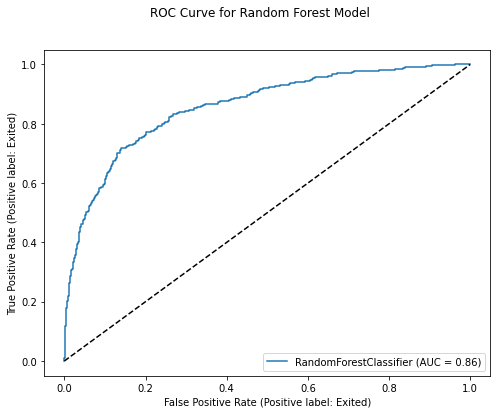

In [39]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, pos_label='Exited', ax=ax)
ax.plot([0, 1], [0, 1], 'k--' )
fig.suptitle('ROC Curve for Random Forest Model')

In [40]:
# Calculate area under roc curve
y_pred_prob = rf_model.predict_proba(X_test) 
roc_auc_score(y_test, y_pred_prob[:, 1])

0.857343270773065

As expected, this performs slightly better than the decision tree model. This is intuitive as the random forest takes an ensemble of decision trees and averages the predictions via bagging. Thus it reduces variance and overfitting and provides more robust predictions.
Next, let's examine which features are the most important for the classification task (according to the RF model). 

In [41]:
px.bar(x=rf_model.feature_names_in_, y=rf_model.feature_importances_)

The results are similar to the DT model, with the most important feature being age, followed by number of products subscribed and balance.